In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from glob import glob

import matplotlib.pyplot as plt

import rioxarray as rio
from shapely.geometry import mapping

%matplotlib inline
# %matplotlib widget

In [3]:
# #### README: to change the region od Interest 
# (1) print hma.Names or hma.Names[ind-of-interest]
# (2) choose the name of a region of interest 
# (3) clip netcdf with the region of interest 

### hma regions

In [4]:
hma = gpd.read_file('HMA_regions/HMA_regions.shp')
# hma.plot()

# as dataframe
hma_df = pd.DataFrame(hma) 
# hma_df.columns
# hma_df.Name[4]

## era5

In [5]:
climate = xr.open_mfdataset('*.nc', decode_coords="all")
# cnange units (and overwrite the metadata with the units after)

#convert temperature K to C
climate['t2m']=climate.t2m-273.15
# precipotation m to mm 
climate['tp']=climate.tp * 1000
# radiation j/m2 to w/m2
# SSR [W/m2] = SSR [J/m^2] / (3600 seconds)
climate['ssrd'] = climate.ssrd / 3600


In [6]:
''' change name of the mountain range here'''

roi = hma[hma['Name'] == 'Central Himalaya']
name = roi.Name
# karakoram.crs

# add crs to the dataset (netcdf file) - maybe this is not even needed 
climate = climate.rio.write_crs('EPSG:4326')

# clip using xarrayrio library:
roi_climate = climate.rio.clip(roi.geometry, roi.crs, drop=True, invert=False)

In [7]:
roi_climate

<xarray.Dataset>
Dimensions:      (latitude: 19, longitude: 49, time: 8784)
Coordinates:
  * latitude     (latitude) float64 31.25 31.0 30.75 30.5 ... 27.25 27.0 26.75
  * longitude    (longitude) float64 77.0 77.25 77.5 77.75 ... 88.5 88.75 89.0
  * time         (time) datetime64[ns] 2012-01-01 ... 2012-12-31T23:00:00
    spatial_ref  int64 0
Data variables:
    ssrd         (time, latitude, longitude) float32 dask.array<chunksize=(8784, 19, 49), meta=np.ndarray>
    t2m          (time, latitude, longitude) float32 dask.array<chunksize=(8784, 19, 49), meta=np.ndarray>
    tcc          (time, latitude, longitude) float32 dask.array<chunksize=(8784, 19, 49), meta=np.ndarray>
    tp           (time, latitude, longitude) float32 dask.array<chunksize=(8784, 19, 49), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-01-18 10:01:30 GMT by grib_to_netcdf-2.7.0: /opt/ecmwf...

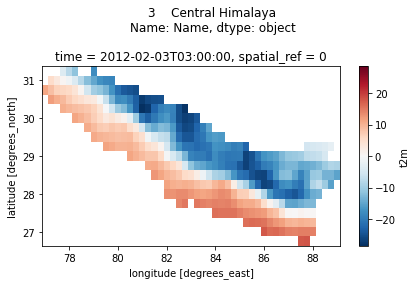

In [51]:
# see how it looks like 

roi_climate.t2m[795,:,:].plot()
plt.suptitle(str(name))
plt.tight_layout()

In [52]:
## convert to dataframe
roi_climate_df = roi_climate.to_dataframe() 
roi_climate_df = roi_climate_df.reset_index()

roi_climate_df = roi_climate_df.dropna()
roi_climate_df = roi_climate_df.drop_duplicates()


In [53]:
roi_climate_df.head()

,latitude,longitude,time,spatial_ref,ssrd,t2m,tcc,tp
26352,31.25,77.75,2012-01-01 00:00:00,0,0.000000,1.000153,0.176659,0.000004
26353,31.25,77.75,2012-01-01 01:00:00,0,0.000000,1.164093,0.239589,0.000004
26354,31.25,77.75,2012-01-01 02:00:00,0,0.757569,0.964569,0.142920,0.000004
26355,31.25,77.75,2012-01-01 03:00:00,0,88.279900,1.790497,0.088108,0.000004
26356,31.25,77.75,2012-01-01 04:00:00,0,261.329132,3.238190,0.104405,0.001065


### how many era5 pizels there are? 

In [89]:
# calculate how many era5 pix fall into the mountain range polygon

x = roi_climate.t2m[1,:,:].values.flatten()
x_count = roi_climate.t2m.median(dim='time').values.flatten().shape
print('total numnber of pixels within bbox:', x_count)

# without nans
x2 = x[~np.isnan(x)]
print('number of not-nan pixels:', x2.shape)

total numnber of pixels within bbox: (931,)
number of not-nan pixels: (376,)


/Users/varyabazilova/opt/anaconda3/envs/project1/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


## make few time-series of some points (randomly)

In [56]:
# generate 5 random pairs of coordinates 
# roi_climate

In [57]:
# create lost of 10 random points: - unnesesary 
# seed? 

# lats = np.random.choice(roi_climate.latitude.to_numpy(), size=10, replace=True, p=None)
# lons = np.random.choice(roi_climate.longitude.to_numpy(), size=10, replace=True, p=None)

In [58]:
# coords = pd.DataFrame({'lons':lons, 'lats':lats})

In [59]:
# random_time_series_t2m_df = random_time_series_t2m.to_dataframe().dropna().drop_duplicates()

### plot ALL time-series of ALL pixels within region roi_climate_df

In [60]:
roi_climate_df.columns

Index(['latitude', 'longitude', 'time', 'spatial_ref', 'ssrd', 't2m', 'tcc',
       'tp'],
      dtype='object')

In [78]:
# (1) sub-select temperatures and precipitation separately: 
t2m = roi_climate_df[['latitude', 'longitude', 'time', 't2m']]
tp =  roi_climate_df[['latitude', 'longitude', 'time', 'tp']]
tcc =  roi_climate_df[['latitude', 'longitude', 'time', 'tcc']]
ssrd =  roi_climate_df[['latitude', 'longitude', 'time', 'ssrd']]




In [91]:
lats_and_lons = roi_climate_df[['latitude', 'longitude']].groupby(['latitude', 'longitude']).size().reset_index()
print('how many unique pairs of coordinates there are:', len(lats_and_lons))

how many unique pairs of coordinates there are: 376


Text(0.5, 1.0, 't2m')

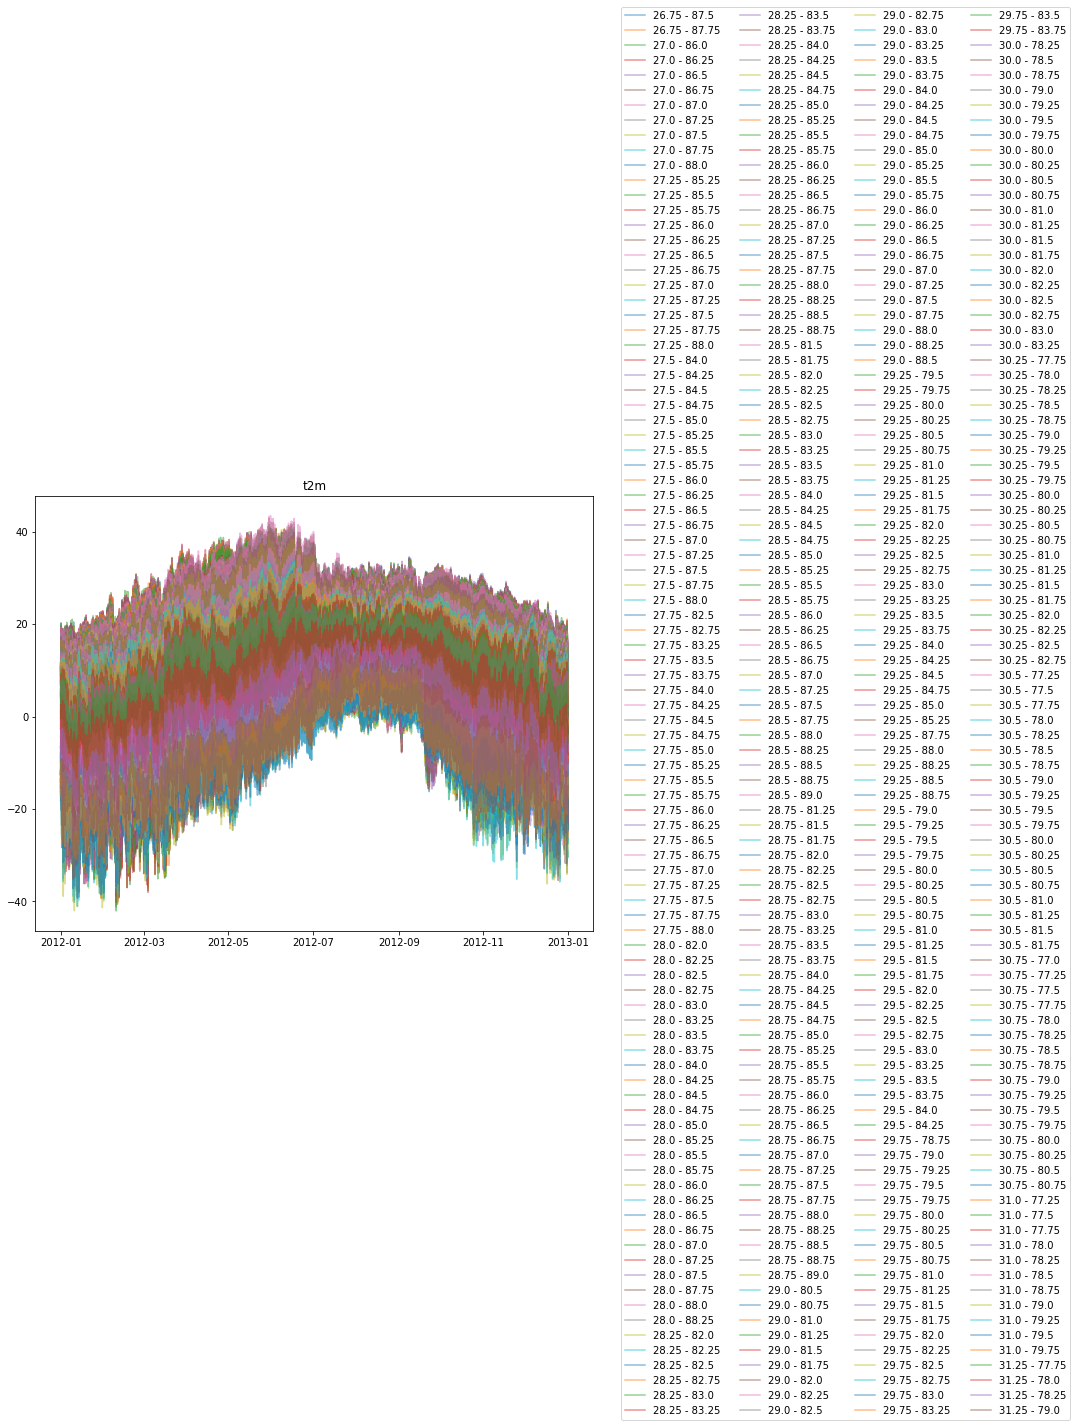

In [81]:
#  TEMPERATURES: 

fig, ax = plt.subplots(figsize=(10, 8))

# short = roi.reset_index()

subs_t2m = []

# for lat, lon in zip(roi.latitude, roi.longitude):

for lat, lon in zip(lats_and_lons.latitude, lats_and_lons.longitude):

# for lat, lon in zip(short.latitude.unique(), short.longitude.unique()):
    # print(lat, lon)
    subdf = t2m[(t2m.latitude==lat) & (t2m.longitude==lon)]
    subdf.set_index('time', inplace=True)
    
    subs_t2m.append(subdf)
    
    ax.plot(subdf.index, subdf.t2m, alpha = 0.5, label='{lat} - {lon}'.format(lat=lat, lon=lon))
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", ncol=4)
plt.title('t2m')


Text(0.5, 1.0, 'tp')

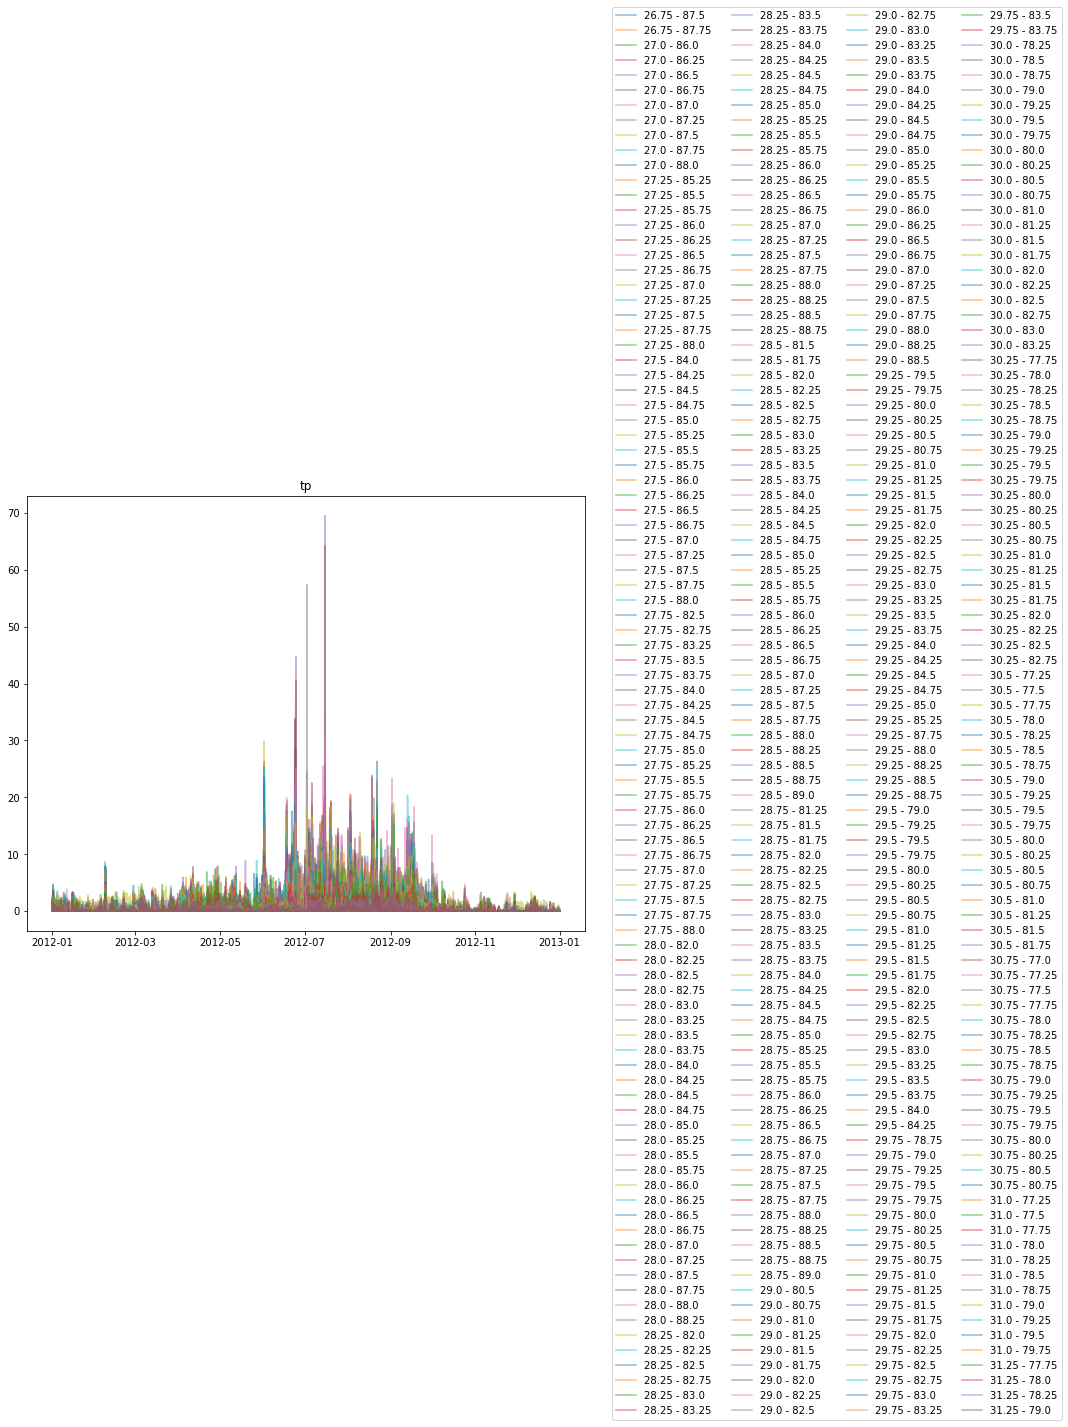

In [82]:
# TOTAL PRECIPITATION (HOURLY)

sub_tp = []

fig, ax = plt.subplots(figsize=(10, 8))

for lat, lon in zip(lats_and_lons.latitude, lats_and_lons.longitude):
    subdf = tp[(tp.latitude==lat) & (tp.longitude==lon)]
    subdf.set_index('time', inplace=True)
    
    sub_tp.append(subdf)
    
    ax.plot(subdf.index, subdf.tp, alpha = 0.5, label='{lat} - {lon}'.format(lat=lat, lon=lon))
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", ncol=4)
plt.title('tp')



In [83]:
# subs[1].tp.plot()